In [19]:
import numpy as np
import random
import os
import cv2
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from matplotlib import pyplot as plt
from keras.models import load_model

# Read data

In [22]:
data = []
labels = []
imagePaths = list(paths.list_images("data"))
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (150, 150))
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

data\Mexican_hairless\n02113978_3670.jpg Mexican_hairless
data\African_hunting_dog\n02116738_10476.jpg African_hunting_dog
data\standard_poodle\n02113799_6984.jpg standard_poodle
data\dingo\n02115641_6228.jpg dingo
data\dhole\n02115913_1142.jpg dhole
data\dingo\n02115641_6309.jpg dingo
data\dingo\n02115641_8871.jpg dingo
data\dhole\n02115913_1830.jpg dhole
data\standard_poodle\n02113799_2765.jpg standard_poodle
data\dhole\n02115913_4163.jpg dhole
data\African_hunting_dog\n02116738_4742.jpg African_hunting_dog
data\standard_poodle\n02113799_5600.jpg standard_poodle
data\Mexican_hairless\n02113978_2996.jpg Mexican_hairless
data\standard_poodle\n02113799_2932.jpg standard_poodle
data\African_hunting_dog\n02116738_2942.jpg African_hunting_dog
data\dingo\n02115641_8578.jpg dingo
data\standard_poodle\n02113799_1976.jpg standard_poodle
data\dingo\n02115641_4563.jpg dingo
data\dingo\n02115641_2424.jpg dingo
data\African_hunting_dog\n02116738_2020.jpg African_hunting_dog
data\dhole\n02115913_13

# Extract train/test data

In [12]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size = 0.25, random_state = 42)
one_hot_encoder = OneHotEncoder()

train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)
train_y = one_hot_encoder.fit_transform(train_y).toarray()
test_y = one_hot_encoder.transform(test_y).toarray()

train_datagen = ImageDataGenerator(rotation_range = 30, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = "nearest")

print(train_x[0].shape, train_y.shape)

(150, 150, 3) (591, 5)


# Build Model

In [13]:
inception_model = InceptionV3(input_shape=train_x[0].shape, include_top=False, weights='imagenet')
for layer in inception_model.layers:
    layer.trainable = False

additional_model = Flatten()(inception_model.output)
additional_model = Dense(1024, activation='relu')(additional_model)
additional_model = Dropout(0.2)(additional_model)
additional_model = Dense(train_y.shape[1], activation='sigmoid')(additional_model)
model = Model(inception_model.input, additional_model)
model.compile(optimizer = RMSprop(learning_rate=0.001), loss = "categorical_crossentropy", metrics = "acc")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

# Extract history

In [14]:
history = model.fit(train_datagen.flow(train_x, train_y), validation_data = (test_x, test_y), epochs = 20, verbose = 2)

Epoch 1/20
19/19 - 14s - loss: 87.6644 - acc: 0.5195 - val_loss: 3.2942 - val_acc: 0.7879 - 14s/epoch - 749ms/step
Epoch 2/20
19/19 - 10s - loss: 7.4205 - acc: 0.7056 - val_loss: 1.8338 - val_acc: 0.8636 - 10s/epoch - 526ms/step
Epoch 3/20
19/19 - 10s - loss: 4.6448 - acc: 0.7563 - val_loss: 2.5754 - val_acc: 0.8384 - 10s/epoch - 535ms/step
Epoch 4/20
19/19 - 10s - loss: 5.3073 - acc: 0.7293 - val_loss: 2.0556 - val_acc: 0.8434 - 10s/epoch - 537ms/step
Epoch 5/20
19/19 - 11s - loss: 3.1545 - acc: 0.7580 - val_loss: 1.4739 - val_acc: 0.8485 - 11s/epoch - 565ms/step
Epoch 6/20
19/19 - 10s - loss: 1.7491 - acc: 0.7750 - val_loss: 1.7503 - val_acc: 0.7677 - 10s/epoch - 537ms/step
Epoch 7/20
19/19 - 11s - loss: 1.5426 - acc: 0.7614 - val_loss: 4.1118 - val_acc: 0.6667 - 11s/epoch - 573ms/step
Epoch 8/20
19/19 - 11s - loss: 1.7896 - acc: 0.7479 - val_loss: 0.5628 - val_acc: 0.8990 - 11s/epoch - 577ms/step
Epoch 9/20
19/19 - 11s - loss: 0.8027 - acc: 0.8105 - val_loss: 0.4024 - val_acc: 0.863

# Evaluate and Predict

In [15]:
model.evaluate(test_x, test_y)
preds = model.predict(test_x)
for i in range(len(preds)):
    print("Pred:", np.argmax(preds[i]), ";", " Real: ", np.argmax(test_y[i]))

7/7 [==============================] - 3s 261ms/step
Pred: 1 ;  True:  1
Pred: 1 ;  True:  1
Pred: 0 ;  True:  0
Pred: 3 ;  True:  3
Pred: 4 ;  True:  4
Pred: 1 ;  True:  1
Pred: 2 ;  True:  2
Pred: 1 ;  True:  1
Pred: 1 ;  True:  1
Pred: 1 ;  True:  1
Pred: 2 ;  True:  2
Pred: 0 ;  True:  0
Pred: 2 ;  True:  2
Pred: 3 ;  True:  2
Pred: 2 ;  True:  2
Pred: 2 ;  True:  2
Pred: 2 ;  True:  2
Pred: 1 ;  True:  1
Pred: 4 ;  True:  4
Pred: 4 ;  True:  4
Pred: 1 ;  True:  3
Pred: 1 ;  True:  2
Pred: 4 ;  True:  4
Pred: 1 ;  True:  1
Pred: 1 ;  True:  1
Pred: 1 ;  True:  3
Pred: 1 ;  True:  0
Pred: 1 ;  True:  1
Pred: 4 ;  True:  4
Pred: 0 ;  True:  0
Pred: 4 ;  True:  4
Pred: 3 ;  True:  3
Pred: 0 ;  True:  0
Pred: 2 ;  True:  2
Pred: 2 ;  True:  2
Pred: 1 ;  True:  1
Pred: 1 ;  True:  1
Pred: 3 ;  True:  3
Pred: 4 ;  True:  4
Pred: 4 ;  True:  4
Pred: 4 ;  True:  4
Pred: 0 ;  True:  0
Pred: 1 ;  True:  3
Pred: 1 ;  True:  3
Pred: 2 ;  True:  2
Pred: 3 ;  True:  3
Pred: 1 ;  True:  1
Pred: 4

# Display results

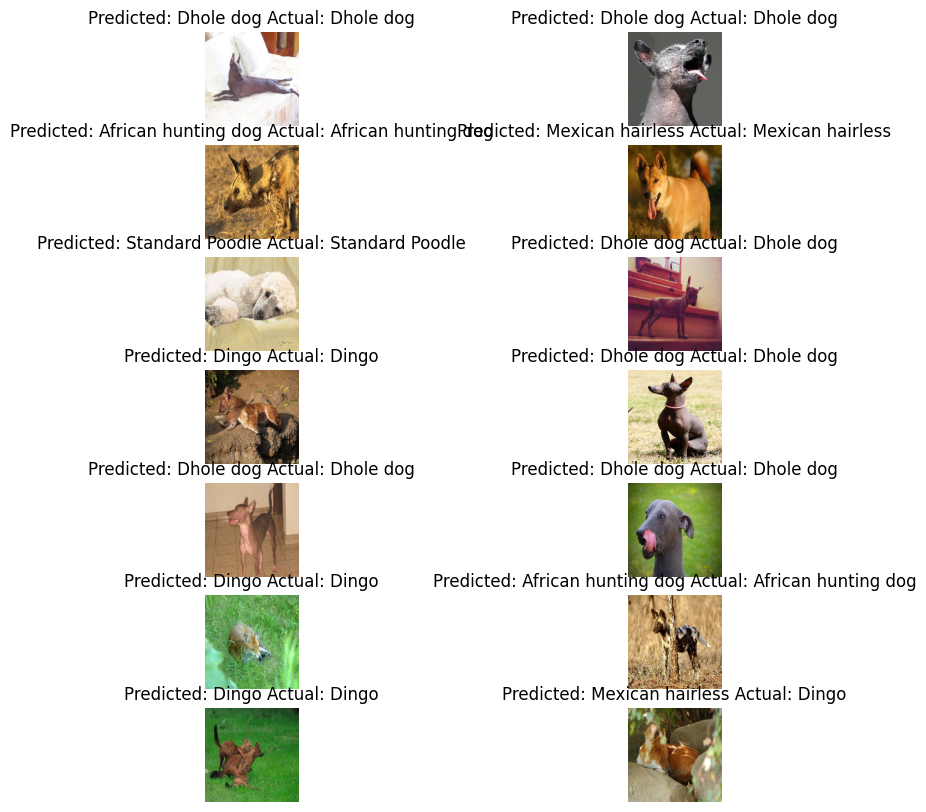

In [16]:
breed_labels = ["African hunting dog", "Dhole dog", "Dingo", "Mexican hairless", "Standard Poodle"]
f = plt.figure(figsize=(10, 10))

n = 14
for i in range(n):
    f.add_subplot(n // 2, 2, i + 1)
    image = test_x[i][:, :, ::-1]
    plt.imshow(image)
    plt.axis("off")
    plt.title("Predicted: " + breed_labels[np.argmax(preds[i])] + " Real: " + breed_labels[np.argmax(test_y[i])])

# Save model

In [17]:
model.save('dog-type-guess-model')

INFO:tensorflow:Assets written to: dog-type-guess-model\assets


INFO:tensorflow:Assets written to: dog-type-guess-model\assets


7/7 [==============================] - 2s 274ms/step


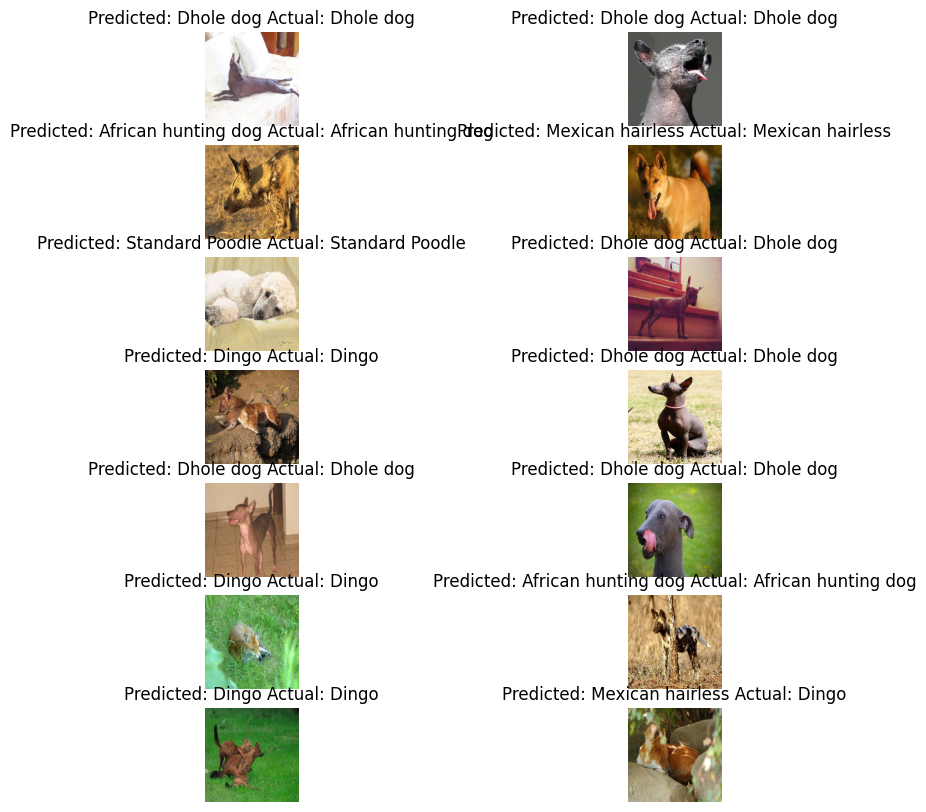

In [20]:
new_model = load_model('dog-type-guess-model')

model.evaluate(test_x, test_y)
preds = model.predict(test_x)

f = plt.figure(figsize=(10, 10))

n = 14
for i in range(n):
    f.add_subplot(n // 2, 2, i + 1)
    image = test_x[i][:, :, ::-1]
    plt.imshow(image)
    plt.axis("off")
    plt.title("Predicted: " + breed_labels[np.argmax(preds[i])] + " Actual: " + breed_labels[np.argmax(test_y[i])])